In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd

from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Our very own survLime!
import survLime
from survLime.utils.generic_utils import fill_matrix_with_total_times
from survLime.datasets.load_datasets import Loader 
from survLime import survlime_tabular


loader = Loader(dataset_name='udca')
x,events, times = loader.load_data()

/home/carlos.hernandez/dl/lib/python3.8/site-packages/pandas/core/series.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [2]:
train, val, test = loader.preprocess_datasets(x, events, times)
events_train = [x[0] for x in train[1]]
times_train  = [x[1] for x in train[1]]

events_val = [x[0] for x in val[1]]
times_val  = [x[1] for x in val[1]]

events_test = [x[0] for x in test[1]]
times_test  = [x[1] for x in test[1]]

In [3]:
model = CoxPHSurvivalAnalysis()
#model = RandomSurvivalForest()
model.fit(train[0], train[1])
model.score(test[0], test[1])

0.7971014492753623

In [33]:
def kernel(d, kernel_width):
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2)) 

In [34]:
from sksurv.nonparametric import nelson_aalen_estimator
from functools import partial
import cvxpy as cp
from math import log
import timeit
import sklearn

# Step one
Ho_t_ = nelson_aalen_estimator(events_train, times_train)[0] # Unique times [0]; CHF [1]

columns = test[0].columns.tolist()
num_pat = 500

# Step two
explainer = survlime_tabular.LimeTabularExplainer(train[0], target_data=train[1], feature_names=columns, class_names=None,
                                                   categorical_features=None, verbose=True, mode='regression', discretize_continuous=False)

synthetic_data = explainer.data_inverse(test[0].iloc[0], num_pat) # At [0] we have the data and at [1]
                                                        #the inverse, see what is this
    
# Third step: Obtain the prediction for the synthetic data 
H_i_j = model.predict_cumulative_hazard_function(synthetic_data[1]) # X_test_t -> [371, num_features]

times_to_fill = list(set(times_train)); times_to_fill.sort()


#Ho_t_ = [fill_matrix_with_total_times(times_to_fill, times_train, list(x.x)) for x in Ho_t_]
H_i_j_wc = [fill_matrix_with_total_times(times_to_fill, x.y, list(x.x)) for x in H_i_j]

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


## Code trials to have it all on the explainer


In [60]:

new = []
log_correction = [np.divide(np.array(x), np.log(np.array(x)+0.0001)) for x in H_i_j_wc]
#H_i_j_wc, weights, log_correction, H_i_j_wc, H0_t_, scaled_data = explainer.explain_instance(

98

In [36]:
kernel_fn = partial(kernel, kernel_width=5)

# We need to do the line 362 from survlime_tabular (scale the data)
scaled_data = synthetic_data[0] # We need to scale this
scaled_data_ = (scaled_data - explainer.scaler.mean_) / explainer.scaler.scale_
distances = sklearn.metrics.pairwise_distances(
            scaled_data,
            scaled_data[0].reshape(1,-1), # <-- Point of inquiry
            metric = 'euclidean').ravel()
weights = kernel_fn(distances)

In [15]:
# Step two
from sksurv.nonparametric import nelson_aalen_estimator
from functools import partial
import cvxpy as cp
from math import log
import timeit
import sklearn

times_to_fill = list(set(times_train)); times_to_fill.sort()
columns = test[0].columns.tolist()
num_pat = 500

explainer = survlime_tabular.LimeTabularExplainer(train[0], target_data=train[1], feature_names=columns, class_names=None,
                                                   categorical_features=None, verbose=True, mode='regression', discretize_continuous=False)

H_i_j_wc, weights, log_correction, H_i_j_wc, Ho_t_, scaled_data = \
                    explainer.explain_instance(test[0].iloc[0], model.predict_survival_function)

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


In [23]:
opt_val = prob.solve(verbose=True, solver=cp.ECOS)


                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 03 04:50:02 PM: Your problem has 4 variables, 0 constraints, and 0 parameters.
(CVXPY) Aug 03 04:50:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 03 04:50:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 03 04:50:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 03 04:50:02 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Aug 03 04:50:02 PM: Finished problem compilation (took 

In [17]:
start_time = timeit.default_timer()
# code you want to evaluate
timeit.default_timer() - start_time

epsilon = 0.00000001
n = train[0].shape[1]  # For now we are only using 3 features
num_times = len(set(times_to_fill))-1
b = cp.Variable(n)


# We are having Conconcave problems here!!
cost = [weights[k]*cp.sum_squares(cp.square(log_correction[k][j])*(log(H_i_j_wc[k][j]+epsilon) - log(Ho_t_[j]+epsilon) - b @ scaled_data[k]))\
        *(times_to_fill[j+1]-times_to_fill[j]) for k in range(num_pat) for j in range(num_times)] # 
#cost = [weights[k]*cp.norm((log(H_i_j_wc[k][j]+epsilon) - log(Ho_t_[j]+epsilon) - b @ scaled_data[k]),'inf') \
#                                            for k in range(num_pat) for j in range(num_times)]
print(f'time creating the cost list {timeit.default_timer() - start_time}')

start_time = timeit.default_timer()
cost_sum = cp.sum(cost)

print(f'time summing the cost list {timeit.default_timer() - start_time}')
start_time = timeit.default_timer()

prob = cp.Problem(cp.Minimize(cost_sum))


opt_val = prob.solve(verbose=True, max_iter=100000)
print(f'time solving the problem {timeit.default_timer() - start_time}')
b.value

time creating the cost list 20.725278034995426
time summing the cost list 41.673555597000814
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 03 04:38:02 PM: Your problem has 4 variables, 0 constraints, and 0 parameters.
(CVXPY) Aug 03 04:38:08 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 03 04:38:08 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 03 04:38:08 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 03 04:38:14 PM: Compiling problem (target solver=OSQP).
(CVX

SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

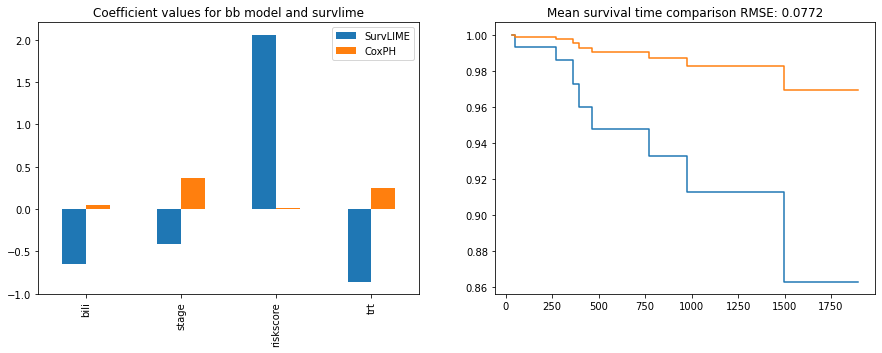

In [62]:
from survLime.utils.generic_utils import compare_survival_times

compare_survival_times(model, b.value, train[0], train[1], test[0])